# **Homework 2 - Semantic Segmentation**

Objective: Implement a U-Net Network for semantic segmentation.



Dataset:

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/drawing1.png'/>
</figure>

You must train the network model by using these images [https://drive.google.com/file/d/1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO/view?usp=sharing]. Image_Train.tif and Reference_Train.tif images and it must be evaluated on Image_Test.tif and Reference_Test.tif images. You can use this notebook that contains some basic functions.

Experimental Protocol

Load the input data
1.     Load the images provided from 2D Semantic Labeling-Vaihingen dataset using the function load_tiff_image(image) and normalize the data into the range [0,1] using the function normalization (image)

Train the FCN model
2.     To train the FCN model you need patches as input. You must extract patches of size w-by-w-by-c pixels from Image_Train and patches with size w-by-w from Reference_Train. The number of patches and the w must be chosen based on the input size of network.

3.     Split randomly the training patches into two sets: Training (80%) and validation (20%).

4.     Convert the patches of the Reference image into one-hot encoding base on the number of classes. Hint: Use the function tf.keras.utils.to_categorical.

5.     Create the function of the U-Net model - Using skip connections: Hint: use tensorflow.keras.layers.concatenate

6.     For training, use the weighted_categorical_crossentropy as a loss function. Hint: To compute the weights you must count the number of pixels of each class and apply the formula: w_i = #total_pixels / #pixels_of_class_i



7.     Train the model using Train_model() function, which has as input the training and validation patches. You must the best model adding the early stop strategy with patience equal to 10.

8.     Extract patches from the test images and test the model using Test(model, patch_test).

9.     Reconstruct the prediction (whole test image)

The report must present the classification results as label images, and report accuracy metrics (overall and average class accuracies, F1-score) you also must change the size of the extracted patches to compare the results (32x32, 64x64, 128x128)

# **Import the libraries**

In [1]:
import os
import gdown
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Conv2D, Input, MaxPool2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


2023-09-27 14:30:28.456605: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 14:30:28.478945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-27 14:30:28.478965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-27 14:30:28.478983: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-27 14:30:28.484305: I tensorflow/core/platform/cpu_feature_g

# Download Data

In [2]:
# url = 'https://drive.google.com/u/0/uc?id=1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO'
# output = 'data.rar'
# gdown.download(url, output, quiet=False)
# !unrar x data.rar


Loading images:


In [2]:
def load_tiff_image(path, grayscale=False):
    image = Image.open(path)
    image = image.convert("L") if grayscale else image

    return np.array(image)


train_image = load_tiff_image("images/Images_Train/Image_Train.tif")
train_reference = load_tiff_image(
    "images/Images_Train/Reference_Train.tif",
    grayscale=True,
)

test_image = load_tiff_image("images/Images_Test/Image_Test.tif")
test_reference = load_tiff_image(
    "images/Images_Test/Reference_Test.tif",
    grayscale=True,
)


Encoding labels:


In [3]:
def one_hot_encode(image: np.ndarray):
    W, H = image.shape

    colors = np.sort(np.unique(image))
    image_encoded = np.zeros((W, H, len(colors)))

    for i, color in enumerate(colors):
        image_encoded[:, :, i] = image == color

    return image_encoded

train_reference_encoded = one_hot_encode(train_reference)
test_reference_encoded = one_hot_encode(test_reference)


In [4]:
def normalization(image: np.ndarray):
    W, H, C = image.shape

    scaler = MinMaxScaler(feature_range=(0, 1))
    image_normalized = scaler.fit_transform(image.reshape((W * H), C))
    image_normalized = image_normalized.reshape(W, H, C)

    return image_normalized

train_image_normalized = normalization(train_image)
test_image_normalized = normalization(test_image)


## Model


Defining the loss function:


In [5]:
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        loss = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
        loss = -K.mean(loss * weights, -1)

        return loss

    return loss


Defining the model:


In [6]:
def convolution_layers(layer, n_filters):
    conv = Conv2D(n_filters, 3, padding="same", activation="relu")(layer)
    conv = Conv2D(n_filters, 3, padding="same", activation="relu")(conv)
    return conv


def downsample_block(layer, n_filters):
    conv = convolution_layers(layer, n_filters)
    pool = MaxPool2D(2)(conv)
    return conv, pool


def upsample_block(layer, conv_features, n_filters):
    layer = UpSampling2D(2)(layer)
    layer = concatenate([layer, conv_features])
    layer = convolution_layers(layer, n_filters)
    return layer


def unet(input_shape, n_classes):
    in_layer = Input(input_shape)
    n_layers = [2 ** i for i in range(3, 8)]

    down_conv1, down_pool1 = downsample_block(in_layer, n_layers[0])
    down_conv2, down_pool2 = downsample_block(down_pool1, n_layers[1])
    down_conv3, down_pool3 = downsample_block(down_pool2, n_layers[2])
    down_conv4, down_pool4 = downsample_block(down_pool3, n_layers[3])

    middle_conv = convolution_layers(down_pool4, n_layers[4])

    up_conv1 = upsample_block(middle_conv, down_conv4, n_layers[3])
    up_conv2 = upsample_block(up_conv1, down_conv3, n_layers[2])
    up_conv3 = upsample_block(up_conv2, down_conv2, n_layers[1])
    up_conv4 = upsample_block(up_conv3, down_conv1, n_layers[0])

    out_layer = Conv2D(n_classes, 1, padding="same", activation="softmax")(up_conv4)

    return keras.Model(in_layer, out_layer)


## Training

Defining auxiliary functions:


In [7]:
def extract_patches(image, size, stride):
    _, _, C = image.shape

    image = np.expand_dims(image, axis=0)
    patches = tf.image.extract_patches(
        images=image,
        sizes=[1, size, size, 1],
        strides=[1, stride, stride, 1],
        rates=[1, 1, 1, 1],
        padding="SAME",
    )

    return patches.numpy().reshape(-1, size, size, C)


def train_model(
    model: keras.Model,
    train_image_patches: np.ndarray,
    train_reference_patches: np.ndarray,
    val_image_patches: np.ndarray,
    val_reference_patches: np.ndarray,
    batch_size,
    epochs,
    name,
):
    print("Start training.. ")

    best_val_loss = np.inf
    early_stopping_counter = 0


    for epoch in range(epochs):
        train_loss = np.zeros((1, 2))
        val_loss = np.zeros((1, 2))

        # Computing the number of batches
        n_batches_train = train_image_patches.shape[0] // batch_size

        # Random shuffle the data
        train_image_patches, train_reference_patches = shuffle(
            train_image_patches,
            train_reference_patches,
            random_state=0,
        )

        # Training the network per batch
        for batch in range(n_batches_train):
            i, j = batch * batch_size, (batch + 1) * batch_size

            x = train_image_patches[i:j, :, :, :]
            y = train_reference_patches[i:j, :, :, :]

            train_loss = train_loss + model.train_on_batch(x, y)

        # Training loss
        train_loss = train_loss / n_batches_train
        print(
            "%d [Training loss: %f , Train acc.: %.2f%%]"
            % (epoch, train_loss[0, 0], 100 * train_loss[0, 1])
        )

        # Computing the number of batchs
        n_batches_val = val_image_patches.shape[0] // batch_size

        # Evaluating the model in the validation set
        for batch in range(n_batches_val):
            i, j = batch * batch_size, (batch + 1) * batch_size

            x = val_image_patches[i:j, :, :, :]
            y = val_reference_patches[i:j, :, :, :]
            val_loss = val_loss + model.test_on_batch(x, y)

        # validation loss
        val_loss = val_loss / n_batches_val
        print(
            "%d [Validation loss: %f , Validation acc.: %.2f%%]"
            % (epoch, val_loss[0, 0], 100 * val_loss[0, 1])
        )

        # Save the best model
        if val_loss[0, 0] < best_val_loss - 1e-3:
            best_val_loss = val_loss[0, 0]
            model.save_weights(name)

            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter == 10:
                break



Defining the parameters:


In [8]:
EXPERIMENTS = [(32, 16), (32, 32), (64, 16), (64, 32), (128, 32)]
VAL_SPLIT = 0.2
N_CHANNELS = train_image_normalized.shape[-1]
N_CLASSES = train_reference_encoded.shape[-1]

weights = np.array(
    [np.sum(train_reference_encoded[:, :, i] == 1) for i in range(N_CLASSES)]
)
weights = weights / np.sum(weights)
weights = 1 / weights

print("Training set shape:  ", train_image_normalized.shape)
print("Test set shape:      ", test_image_normalized.shape)
print("Experiments:         ", EXPERIMENTS)
print("Validation split:    ", VAL_SPLIT)
print("Number of classes:   ", N_CLASSES)
print("Number of channels:  ", N_CHANNELS)
print("Weights:             ", weights)


Training set shape:   (2565, 1919, 3)
Test set shape:       (2558, 2818, 3)
Experiments:          [(32, 16), (32, 32), (64, 16), (64, 32), (128, 32)]
Validation split:     0.2
Number of classes:    5
Number of channels:   3
Weights:              [  5.67350328   2.97682037   3.92124661 374.0300152    4.34558461]


In [37]:
for patch_size, stride in EXPERIMENTS:
    if os.path.exists(f"model_{patch_size}_{stride}.h5"):
        print(f"Model already trained: path_size={patch_size}, stride={stride}")
        continue
    
    # Extract training patches
    train_image_patches = extract_patches(train_image_normalized, patch_size, stride)
    train_reference_patches = extract_patches(train_reference_encoded, patch_size, stride)

    # Split the training patches into training and validation sets
    train_image_patches, train_reference_patches = shuffle(
        train_image_patches, train_reference_patches, random_state=0
    )

    train_size = int(train_image_patches.shape[0] * (1 - VAL_SPLIT))

    train_image_patches, val_image_patches = (
        train_image_patches[:train_size],
        train_image_patches[train_size:],
    )

    train_reference_patches, val_reference_patches = (
        train_reference_patches[:train_size],
        train_reference_patches[train_size:],
    )

    # Train the model
    adam = Adam(learning_rate=0.0001)
    model = unet((patch_size, patch_size, N_CHANNELS), N_CLASSES)
    loss = weighted_categorical_crossentropy(weights)
    model.summary()
    model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])

    train_model(
        model,
        train_image_patches,
        train_reference_patches,
        val_image_patches,
        val_reference_patches,
        batch_size=128,
        epochs=100,
        name=f"model_{patch_size}_{stride}.h5",
    )



15456 3864
15456 3864


## Testing

In [28]:
def get_model(experiment):
    patch_size, stride = experiment
    adam = Adam(learning_rate=0.0001)
    model = unet((patch_size, patch_size, N_CHANNELS), N_CLASSES)
    loss = weighted_categorical_crossentropy(weights)
    model.compile(loss=loss, optimizer=adam, metrics=["accuracy"])
    model.load_weights(f"model_{patch_size}_{stride}.h5")
    return model

def test(model: keras.Model, patch_test):
    result = model.predict(patch_test)
    predicted_class = np.argmax(result, axis=-1)
    return predicted_class

def compute_metrics(true_labels, predicted_labels):
    accuracy = 100 * accuracy_score(true_labels, predicted_labels)
    f1score = 100 * f1_score(true_labels, predicted_labels, average=None)
    recall = 100 * recall_score(true_labels, predicted_labels, average=None)
    precision = 100 * precision_score(true_labels, predicted_labels, average=None)
    return accuracy, f1score, recall, precision

def reconstruct_image(patches, image_size, patch_size):
    image = np.zeros(image_size)
    count = 0

    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            if count == patches.shape[0]:
                return image

            image_slice = image[i:i+patch_size, j:j+patch_size]
            W, H = image_slice.shape[:2]

            image[i:i+patch_size, j:j+patch_size] = patches[count, :W, :H]
            count += 1

    return image


In [47]:
def show_results(model, patch_size):
    test_image_patches = extract_patches(test_image_normalized, patch_size, patch_size)
    test_reference_patches = extract_patches(
        test_reference_encoded,
        patch_size,
        patch_size,
    )

    # Compute the predicted labels
    predicted_labels = test(model, test_image_patches)
    predicted_labels_array = predicted_labels.reshape(-1)

    # Compute the true labels
    true_labels = np.argmax(test_reference_patches, axis=-1)
    true_labels_array = true_labels.reshape(-1)

    # Compute the metrics
    accuracy, f1score, recall, precision = compute_metrics(
        true_labels_array,
        predicted_labels_array,
    )

    # Print the metrics
    print("Accuracy:  ", accuracy)
    print("F1 score:  ", f1score)
    print("Recall:    ", recall)
    print("Precision: ", precision)

    reconstructed_image = reconstruct_image(
        predicted_labels, test_reference.shape, patch_size
    )

    fig, ax = plt.subplots(1, 3, figsize=(21, 7))

    ax[0].imshow(test_image)
    ax[1].imshow(test_reference_encoded.argmax(axis=-1))
    ax[2].imshow(reconstructed_image)

    plt.show()


15/15 [==============================] - 0s 24ms/step
Accuracy:   66.85629139775816
F1 score:   [69.5862128  72.3037506  53.98343331 24.21114633 75.46353698]
Recall:     [65.59409037 88.63021416 45.95791305 15.96035796 75.30795866]
Precision:  [74.09575511 61.05659058 65.40494157 50.12193706 75.61975944]


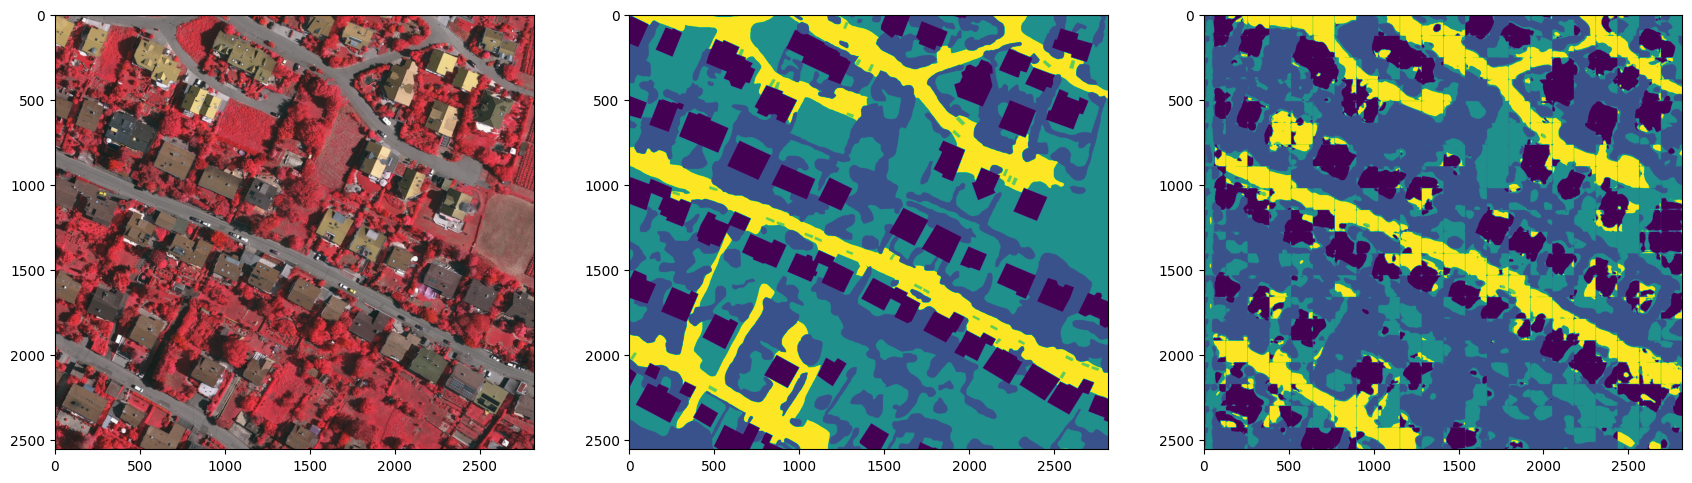

In [48]:
show_results(get_model((128, 32)), 128)